### Subgraphs in LangGraph

#### Subgraphs with Isolated State Mechanism

In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from typing import TypedDict

In [2]:
subgraph_llm = ChatOllama(model="gpt-oss:20b-cloud")
subgraph_llm

ChatOllama(model='gpt-oss:20b-cloud')

In [3]:
class SubgraphState(TypedDict):
    input_text: str
    translated_text: str

In [6]:
def translate_text(state: SubgraphState):
    """
    Takes input text and translates to the mentioned language in the prompt
    """
    prompt = f"""
    Translate the following text to hindi.
    Keep it natural, clear and to the point. No need to add any extra content
    
    Text:
    {state["input_text"]}
    """.strip()

    translated_text = subgraph_llm.invoke(prompt).content

    return {"translated_text" : translated_text}

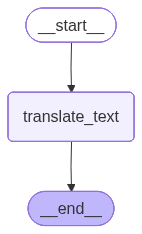

In [7]:
# Creating the subgraph
subgraph = StateGraph(SubgraphState)

# Adding nodes to the subgraph
subgraph.add_node("translate_text", translate_text)

# Adding edges to the subgraph
subgraph.add_edge(START, "translate_text")
subgraph.add_edge("translate_text", END)

# Compiling the subgraph
subgraph = subgraph.compile()
subgraph

In [8]:
class ParentState(TypedDict):
    question: str
    answer_eng: str
    answer_hindi: str

In [9]:
parent_llm = ChatOllama(model="gpt-oss:20b-cloud")
parent_llm

ChatOllama(model='gpt-oss:20b-cloud')

In [10]:
def generate_answer(state: ParentState):
    answer = parent_llm.invoke(f"You are a helpful assistant. Answer clearly.\n\nQuestion : {state['question']}").content
    return{"answer_eng" : answer}

In [11]:
def translate_answer(state: ParentState):
    result = subgraph.invoke({"input_text" : state["answer_eng"]})
    return {"answer_hindi" : result["translated_text"]}

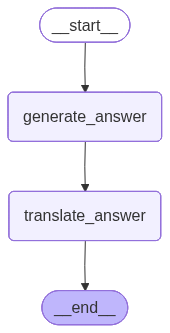

In [12]:
# Creating the parent graph
parent_graph = StateGraph(ParentState)

# Adding nodes to the graph
parent_graph.add_node("generate_answer", generate_answer)
parent_graph.add_node("translate_answer", translate_answer)

# Adding edges to the graph
parent_graph.add_edge(START, "generate_answer")
parent_graph.add_edge("generate_answer", "translate_answer")
parent_graph.add_edge("translate_answer", END)

# Compiling the parent graph
graph = parent_graph.compile()
graph

In [13]:
graph.invoke({"question" : "What is machine learning"})

{'question': 'What is machine learning',
 'answer_eng': '**Machine learning** is a subfield of artificial intelligence that enables computers to learn patterns and make decisions from data, without being explicitly programmed for each specific task.\n\nKey points:\n\n1. **Learning from data**  \n   - A machine learning algorithm takes a set of inputs (features) and an associated outcome (label) and discovers a statistical relationship between them.\n\n2. **Model building**  \n   - The algorithm creates a *model*—a mathematical function or rule set—that can predict or explain relationships for new, unseen data.\n\n3. **Evaluation and improvement**  \n   - The model’s predictions are compared with actual outcomes, giving a *loss* or *error* metric. The algorithm adjusts its internal parameters to reduce this error, iterating until acceptable performance is achieved.\n\n4. **Types of learning**  \n   - **Supervised learning**: uses labeled data (e.g., classifying emails as spam/non‑spam).

#### Subgraphs with Shared State Mechanism

In [14]:
class ParentState(TypedDict):
    question: str
    answer_eng: str
    answer_hindi: str

In [15]:
subgraph_llm = ChatOllama(model="gpt-oss:20b-cloud")
subgraph_llm

ChatOllama(model='gpt-oss:20b-cloud')

In [16]:
parent_llm = ChatOllama(model="gpt-oss:20b-cloud")
parent_llm

ChatOllama(model='gpt-oss:20b-cloud')

In [17]:
def translate_text(state: ParentState):
    prompt = f"""
    Translate the following text to hindi.
    Keep it natural, clear and to the point. No need to add any extra content.

    Text:
    {state['answer_eng']}
    """.strip()

    result = subgraph_llm.invoke(prompt)

    return {"answer_hindi" : result.content}

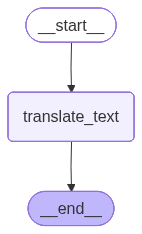

In [18]:
# Creating the subgraph
subgraph = StateGraph(ParentState)

# Adding nodes to the subgraph
subgraph.add_node("translate_text", translate_text)

# Adding edges to the subgraph
subgraph.add_edge(START, "translate_text")
subgraph.add_edge("translate_text", END)

# Compiling the subgraph
subgraph = subgraph.compile()
subgraph

In [19]:
def generate_answer(state: ParentState):
    answer = parent_llm.invoke(f"You are a helpful assistant. Answer clearly\n\nQuestion: {state['question']}").content
    return {'answer_eng' : answer}

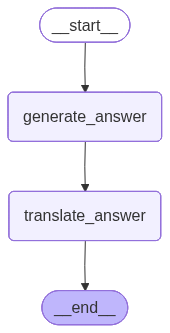

In [20]:
# Creating the parent graph
parent_graph = StateGraph(ParentState)

# Adding nodes to the graph
parent_graph.add_node("generate_answer", generate_answer)
parent_graph.add_node("translate_answer", subgraph)

# Adding edges to the graph
parent_graph.add_edge(START, "generate_answer")
parent_graph.add_edge("generate_answer", "translate_answer")
parent_graph.add_edge("translate_answer", END)

# Compiling the parent graph
graph = parent_graph.compile()
graph

In [21]:
graph.invoke({"question" : "What is machine learning"})

{'question': 'What is machine learning',
 'answer_eng': '**Machine learning** is a branch of artificial intelligence that gives computers the ability to learn automatically from data, identify patterns, and make decisions or predictions without being explicitly programmed for each specific task.\n\nKey points:\n\n1. **Learning from data** – Instead of hard‑coding rules, a machine‑learning system is fed a large set of examples (data) and uses statistical techniques to discover relationships or regularities.\n2. **Models and algorithms** – The system builds a *model* (a mathematical representation) that approximates the underlying pattern. Common algorithms include linear regression, decision trees, support vector machines, neural networks, etc.\n3. **Training and evaluation** – The model is *trained* by adjusting its internal parameters to minimize error on the training data. Its performance is then assessed on unseen data (validation or test sets) to ensure it generalizes well.\n4. **T